In [159]:
import warnings
warnings.filterwarnings('ignore')
import torch
dtype = torch.float
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from torch.distributions import normal
import matplotlib.pyplot as plt, numpy as np, pickle
from scipy.stats import norm
from tifffile import imread
import sys
sys.path.append('../')
#from pn2v import *
from lib.gaussianMixtureNoiseModel import GaussianMixtureNoiseModel
from lib import histNoiseModel
from lib.utils import plotProbabilityDistribution
import os
import urllib
import zipfile
from pathlib import Path
import math
from pystackreg import StackReg
from skimage.transform import warp,AffineTransform

In [160]:
def crop_center(img,crop_size):

    if type(crop_size) == tuple:
        crop_x,crop_y = crop_size
    elif type(crop_size) == int:
        crop_x = crop_size
        crop_y = crop_size
    
    y,x = img.shape[-2::]
    startx = x//2-(crop_x//2)
    starty = y//2-(crop_y//2)        

    return img[...,starty:starty+crop_y,startx:startx+crop_x]

In [161]:
# Data paths
data_path = Path(r"E:\dl_monalisa\Data\Mito_fixed\dump")
crop_size = (1200,1200)

# Choose parameters
noise_level = "all" # "all",list of int, or int
clean = "avg" 
display = True # display images and histograms or not
hist_bins = 512
clip = -5 # False or clip value
registration = False

# Saving dir parameters
if isinstance(noise_level,list):
    noise_level_str = ''.join(str(noise_level).split(', '))[1:-1]
else:
    noise_level_str = noise_level
noiseModelsDir = r"E:\dl_monalisa\Data\Mito_fixed\noise_models"
nameHistNoiseModel = f"Hist_Noise{noise_level_str}_Sig{clean.upper()}_Clip{clip}"
nameGMMNoiseModel = f"GMM_Noise{noise_level_str}_Sig{clean.upper()}_Clip{clip}"

print(f"Noise level: {noise_level}")
print(f"Clean: {clean}")

print(f"Saving at: {noiseModelsDir}")
print(f"Histogram based noise model saving name: {nameHistNoiseModel}")
print(f"GMM based noise model saving name: {nameGMMNoiseModel}")

signal = []
observation = []
filters = ['tif','tiff']

files = os.listdir(data_path)

for f in files:
    if f.split('.')[-1] not in filters:
        print(f"removing {f} in signals because not in filters")
        files.remove(f)

for f in files:
    if f.split('.')[-1] not in filters:
        print(f"Removing {f} in observations because not in filters")
        files.remove(f)

print(f"\nFound {len(files)} files.\n")

if isinstance(noise_level,list) or noise_level == "all":
    mltplNoise = True
else:
    mltplNoise = False

for f in files:
    
    if clean == "avg":
        im_signal = np.mean(imread(data_path / f)[0:5],axis=0)
    else:
        raise ValueError("avg gt is the only one available for now for actin")
    
    # noise level selection
    if noise_level == "all":
        im_obs  = imread(data_path / f)
    elif isinstance(noise_level,int) or isinstance(noise_level,list):
        try:
            im_obs = imread(data_path / f)[noise_level]
        except IndexError:
            print(f"Image {f} ignored because of IndexError") 
            continue

    if not isinstance(clip,bool):
        im_obs[im_obs<clip] = clip
        im_signal[im_signal<clip] = clip

    if registration:
        if mltplNoise:
            print("Registration not available for multiple noise level")
        else:
            tf = StackReg.TRANSLATION
            sr = StackReg(tf)
            tmat = sr.register(ref=im_signal,mov=im_obs)
            tform = AffineTransform(matrix=tmat)
            im_obs = warp(im_obs, tform,order=0)

    im_obs = crop_center(im_obs,crop_size)
    im_signal = crop_center(im_signal,crop_size)
    
    observation.append(im_obs)
    signal.append(im_signal)

    print(f"File {f}: shape: {im_obs.shape}")


Noise level: all
Clean: avg
Saving at: E:\dl_monalisa\Data\Mito_fixed\noise_models
Histogram based noise model saving name: Hist_Noiseall_SigAVG_Clip-5
GMM based noise model saving name: GMM_Noiseall_SigAVG_Clip-5

Found 28 files.

File 12h08m06s_rec_scan00_CAM.hdf5_multi.0.reconstruction.tiff: shape: (20, 1200, 1200)
File 12h11m06s_rec_scan00_CAM.hdf5_multi.0.reconstruction.tiff: shape: (17, 1200, 1200)
File 12h14m16s_rec_scan00_CAM.hdf5_multi.0.reconstruction.tiff: shape: (19, 1200, 1200)
File 12h17m11s_rec_scan00_CAM.hdf5_multi.0.reconstruction.tiff: shape: (19, 1200, 1200)
File 12h19m41s_rec_scan00_CAM.hdf5_multi.0.reconstruction.tiff: shape: (20, 1200, 1200)
File 12h23m09s_rec_scan00_CAM.hdf5_multi.0.reconstruction.tiff: shape: (20, 1200, 1200)
File 12h25m12s_rec_scan00_CAM.hdf5_multi.0.reconstruction.tiff: shape: (20, 1200, 1200)
File 12h28m54s_rec_scan00_CAM.hdf5_multi.0.reconstruction.tiff: shape: (20, 1200, 1200)
File 12h31m33s_rec_scan00_CAM.hdf5_multi.0.reconstruction.tiff: 

In [162]:
full_signal = []
full_obs = []
for i,obs in enumerate(observation):
    sig = signal[i]
    sig = (sig - np.mean(sig))/np.std(sig)
    for frame in obs:
        norm_sig = sig * np.std(frame) + np.mean(frame)
        full_signal.append(norm_sig)
        full_obs.append(frame)


In [163]:
full_obs = np.stack(full_obs)
full_signal = np.stack(full_signal)

# # reshape im mltpl noise case
# if mltplNoise:
#     nNoise = observation.shape[1]
#     observation = np.reshape(observation,(observation.shape[0]*observation.shape[1],observation.shape[2],observation.shape[3]))    
#     signal = np.repeat(signal,nNoise,axis=0)

# # signal = (signal - np.mean(signal))/np.std(signal)
# # if mltplNoise:
# #     for noise in range(nNoise):
# #         observation[noise::nNoise] = (observation[noise::nNoise] - np.mean(observation[noise::nNoise]))/np.std(observation[noise::nNoise])
# # else:
# #     observation = (observation - np.mean(observation))/np.std(observation)


# # Normalize the signal range to the observation range
# if mltplNoise:
#     signal = (signal - np.mean(signal))/np.std(signal)
#     for noise in range(nNoise):
#         signal[noise::nNoise] = signal[noise::nNoise] * np.std(observation[noise::nNoise]) + np.mean(observation[noise::nNoise])
# else:
#     signal = (signal - np.mean(signal))/np.std(signal)
#     signal = signal * np.std(observation) + np.mean(observation)

minVal = np.min(full_signal)
maxVal = np.max(full_signal)
# minValnorm = np.min(signalnorm)
# maxValnorm = np.max(signalnorm)

print(f"\n\nConcatenated arrays:\tSignal: {full_signal.shape}\tObservation: {full_obs.shape}")




Concatenated arrays:	Signal: (526, 1200, 1200)	Observation: (526, 1200, 1200)


In [164]:

print(np.min(full_obs), np.max(full_obs))
print(np.mean(full_obs),np.std(full_obs))

-5.0 6297.764
24.795685 84.972084


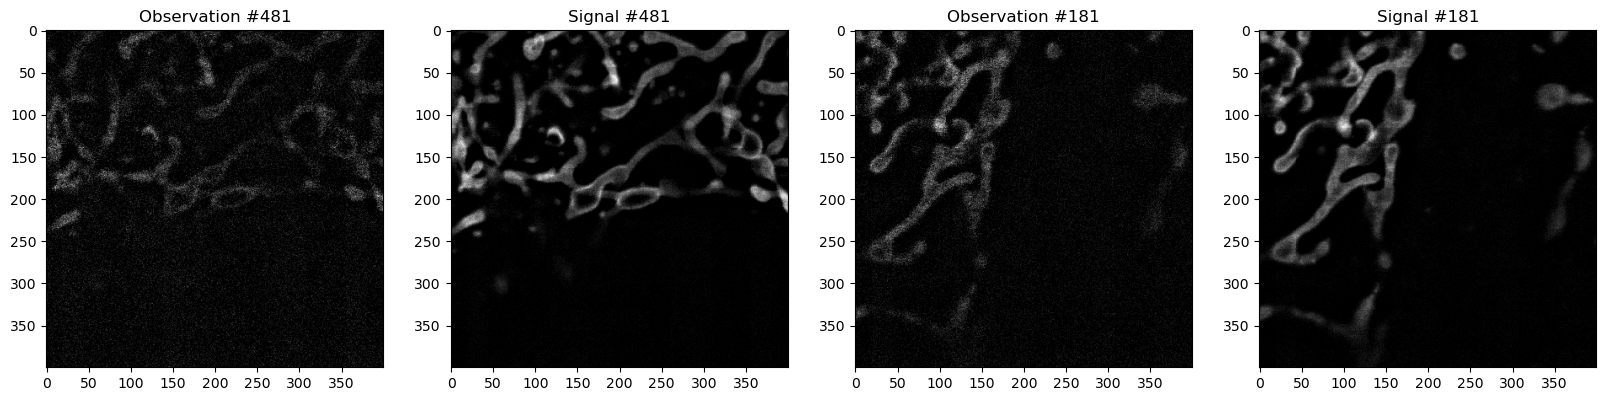

In [165]:
# Display examples of signals and observations if display is set to True

crop_size = 400
h,w = signal[0].shape

starty,startx = h//2-crop_size//2, w//2-crop_size//2
stopy,stopx = h//2+crop_size//2,w//2+crop_size//2

if display:
    idxs = np.random.randint(0,full_signal.shape[0],2)
    plt.figure(figsize=(20,10))
    for i in range(len(idxs)):
        sig = full_signal[idxs[i],starty:stopy,starty:stopy]
        obs = full_obs[idxs[i],starty:stopy,starty:stopy]
        plt.subplot(1,4,2*i+1)
        plt.imshow(obs,cmap="gray")
        plt.title(f"Observation #{idxs[i]}")
        plt.subplot(1,4,2*i+2)
        plt.imshow(sig,cmap="gray")
        plt.title(f"Signal #{idxs[i]}")

Hist noise model saved at E:\dl_monalisa\Data\Mito_fixed\noise_models\Hist_Noiseall_SigAVG_Clip-5


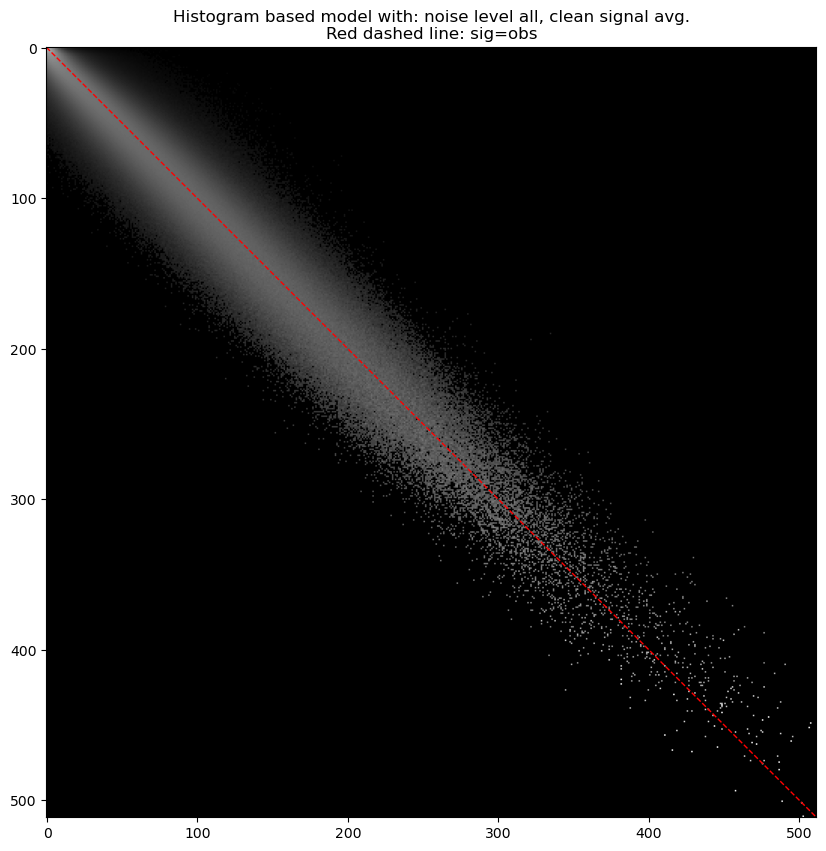

In [166]:
# Create, save and display histogram-based model

plt.figure(figsize=(10,10))
histogram = histNoiseModel.createHistogram(hist_bins, minVal, maxVal, full_obs,full_signal)

# Saving histogram
save_path = os.path.join(noiseModelsDir, nameHistNoiseModel)
np.save(save_path, histogram)
print(f"Hist noise model saved at {save_path}")

# Optional display
if display:
    plt.title(f"Histogram based model with: noise level {noise_level}, clean signal {clean}.\nRed dashed line: sig=obs")
    plt.imshow(histogram[0]**0.25, cmap='gray')
    plt.axline(xy1=(0,0),slope=1,color="red",linestyle="--",linewidth=1)
    plt.show()


In [167]:
# Training GMM noise model
n_gaussian = 5# Number of gaussians to use for Gaussian Mixture Model
n_coeff = 6# No. of polynomial coefficients for parameterizing the mean, standard deviation and weight of Gaussian components.
fullnameGMMNoiseModel = f"/{nameGMMNoiseModel}_nGauss{n_gaussian}_nCoeff{n_coeff}"

gaussianMixtureNoiseModel = GaussianMixtureNoiseModel(min_signal = minVal,
                                                    max_signal = maxVal,
                                                    path=str(noiseModelsDir), weight = None, 
                                                    n_gaussian = n_gaussian,
                                                    n_coeff = n_coeff,
                                                    min_sigma = 1, 
                                                    device = device)

gaussianMixtureNoiseModel.train(full_signal, full_obs, batchSize = 250000, n_epochs =1000, learning_rate=0.05, name = fullnameGMMNoiseModel,lowerClip=0)

Starting with loss = 10.468297958374023
0 10.468297958374023
Epoch 1: saved with loss 10.29183578491211
Epoch 2: saved with loss 10.078295707702637
Epoch 3: saved with loss 9.888121604919434
Epoch 4: saved with loss 9.752229690551758
Epoch 5: saved with loss 9.552842140197754
Epoch 6: saved with loss 9.378376007080078
Epoch 7: saved with loss 9.194104194641113
Epoch 8: saved with loss 9.036622047424316
Epoch 9: saved with loss 8.895228385925293
Epoch 10: saved with loss 8.731053352355957
Epoch 11: saved with loss 8.62540340423584
Epoch 12: saved with loss 8.455862045288086
Epoch 13: saved with loss 8.32873821258545
Epoch 14: saved with loss 8.173243522644043
Epoch 15: saved with loss 8.07546615600586
Epoch 16: saved with loss 7.916798114776611
Epoch 17: saved with loss 7.800836086273193
Epoch 18: saved with loss 7.715946197509766
Epoch 19: saved with loss 7.564803123474121
Epoch 20: saved with loss 7.453402996063232
Epoch 21: saved with loss 7.366268157958984
Epoch 22: saved with loss 

GMM_Noiseall_SigAVG_Clip-5_nGauss5_nCoeff6.npz


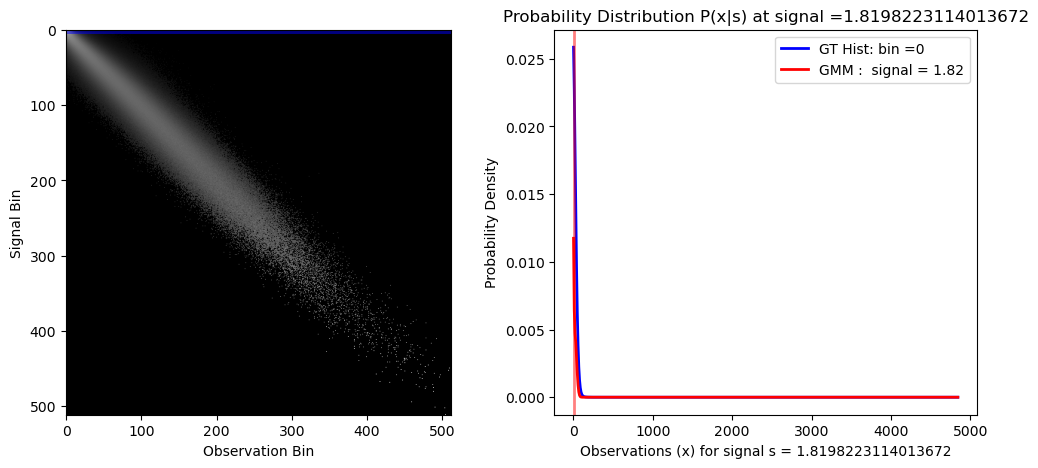

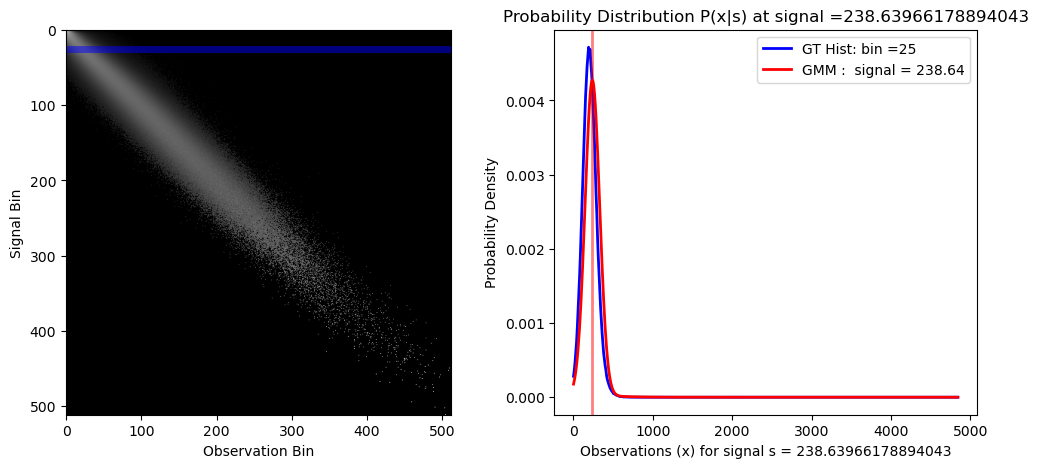

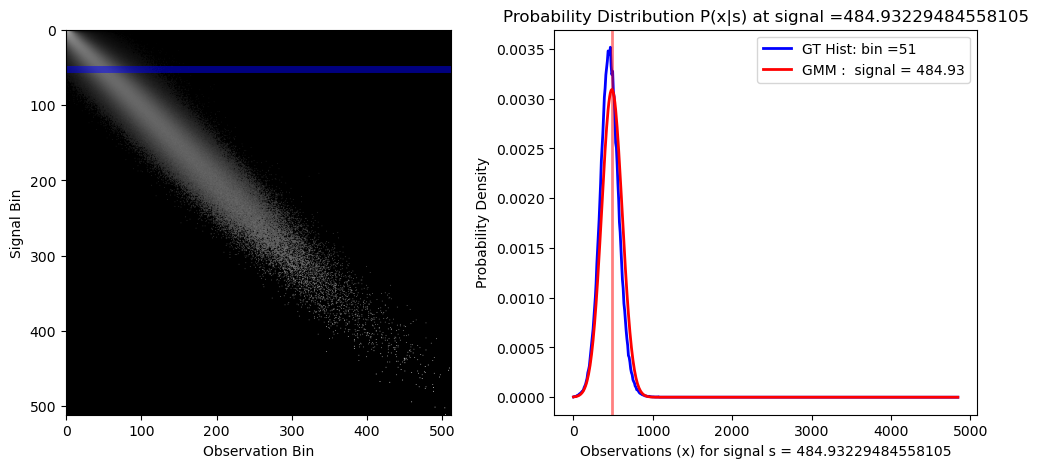

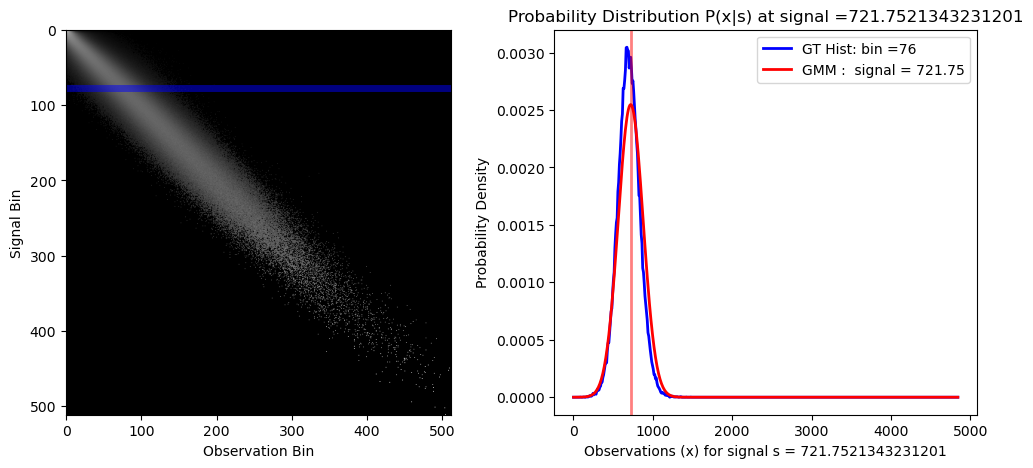

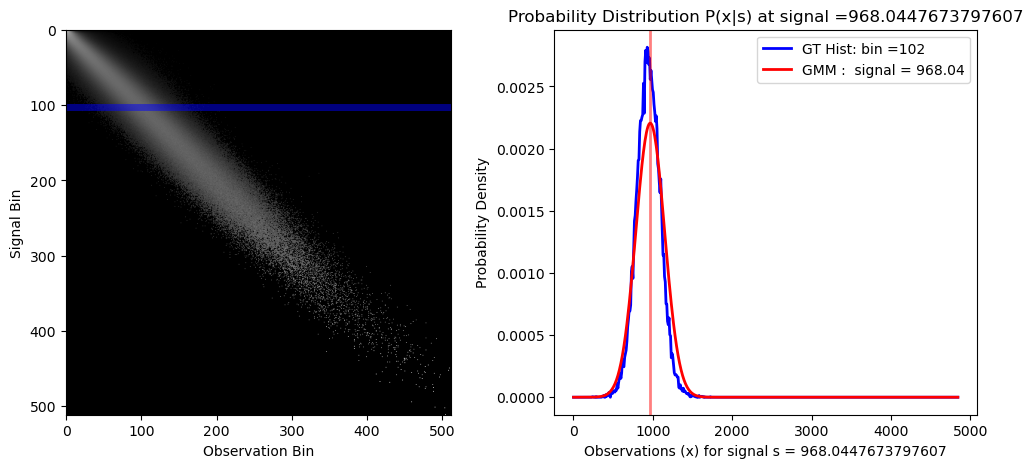

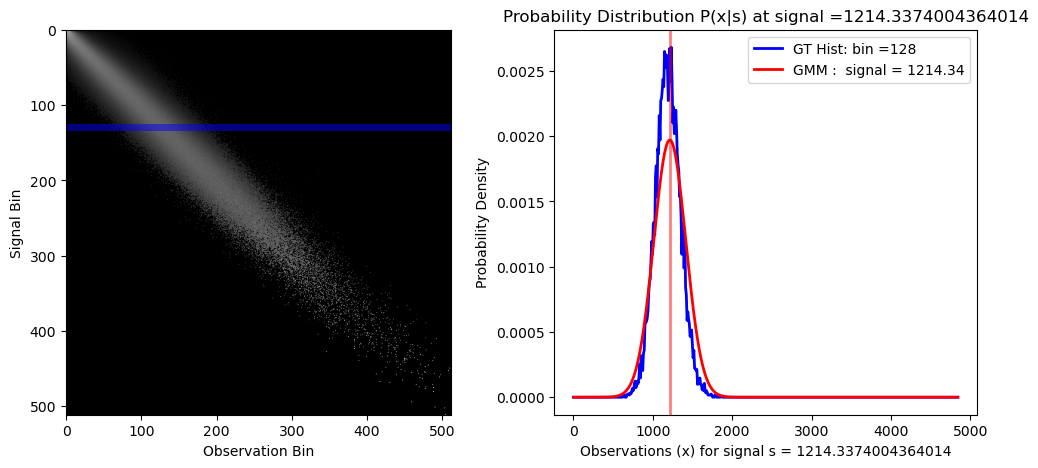

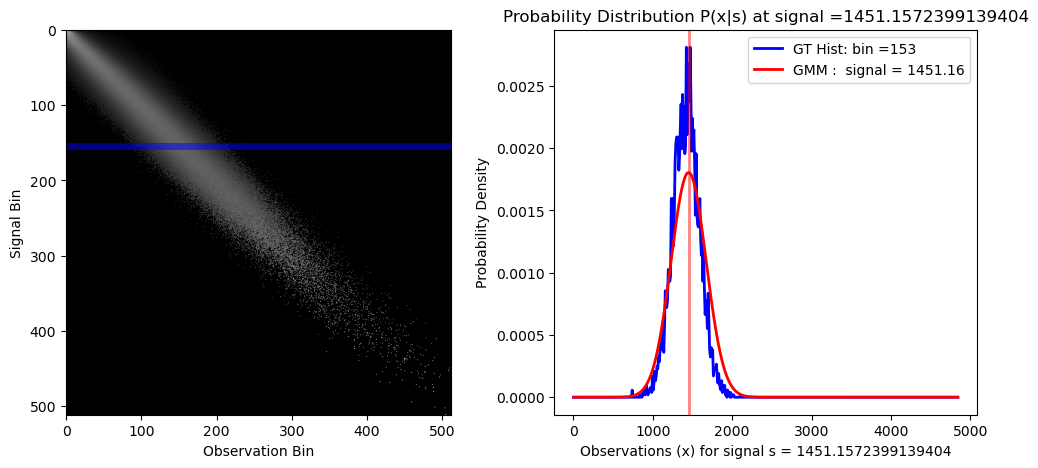

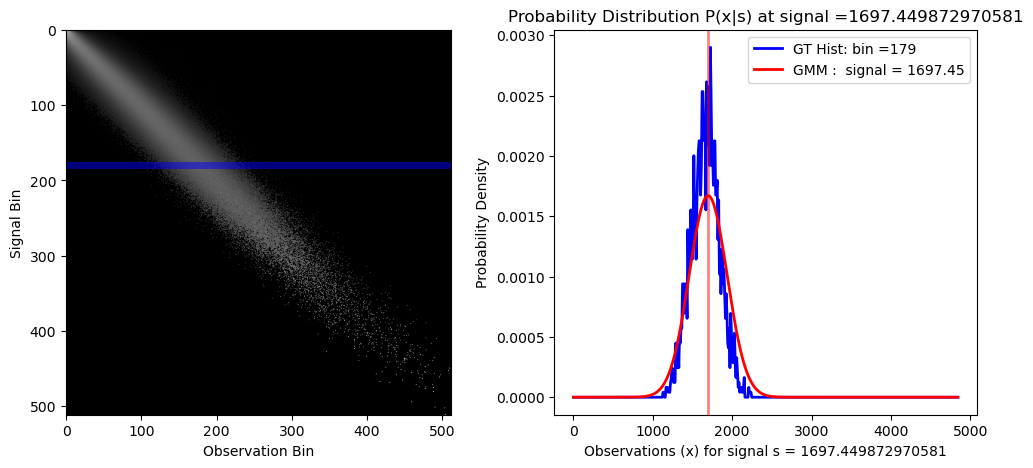

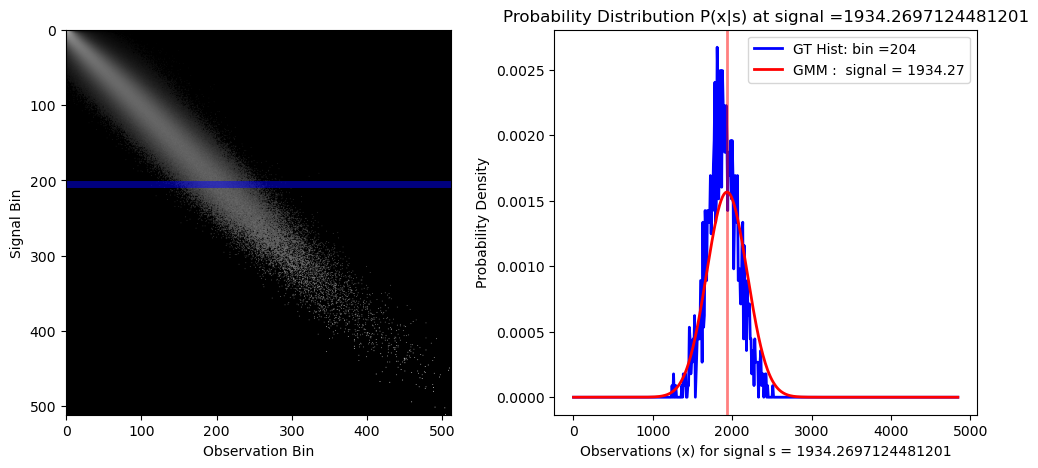

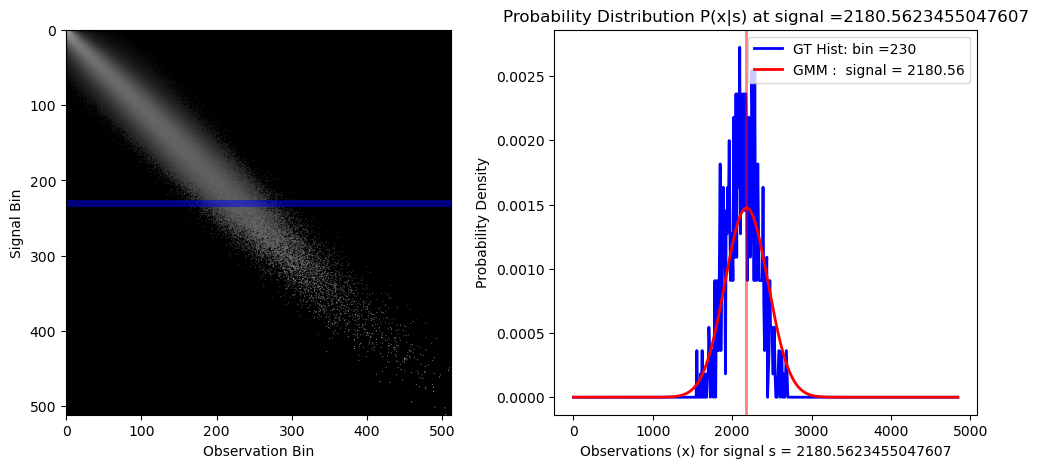

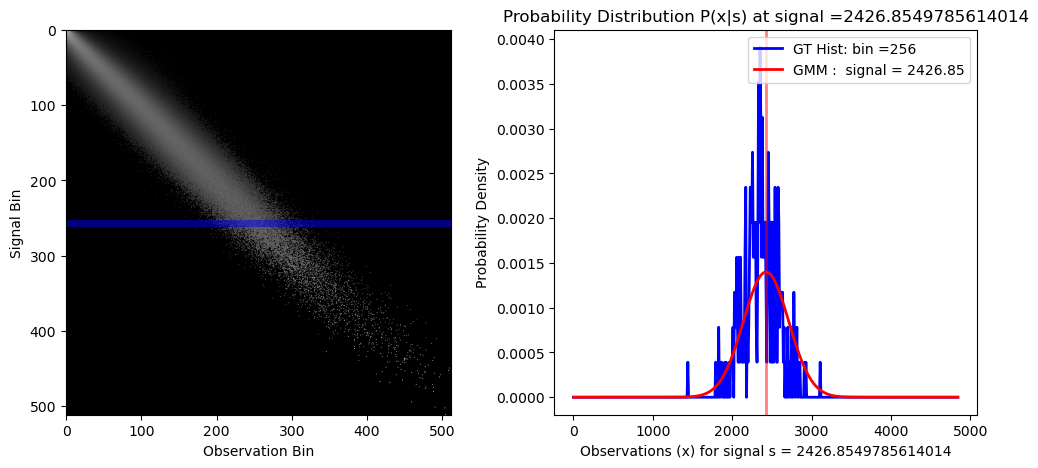

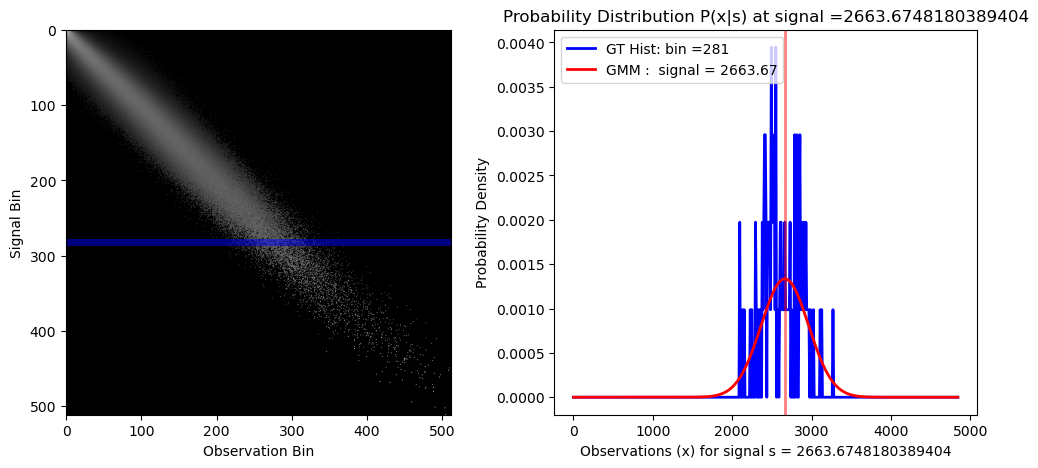

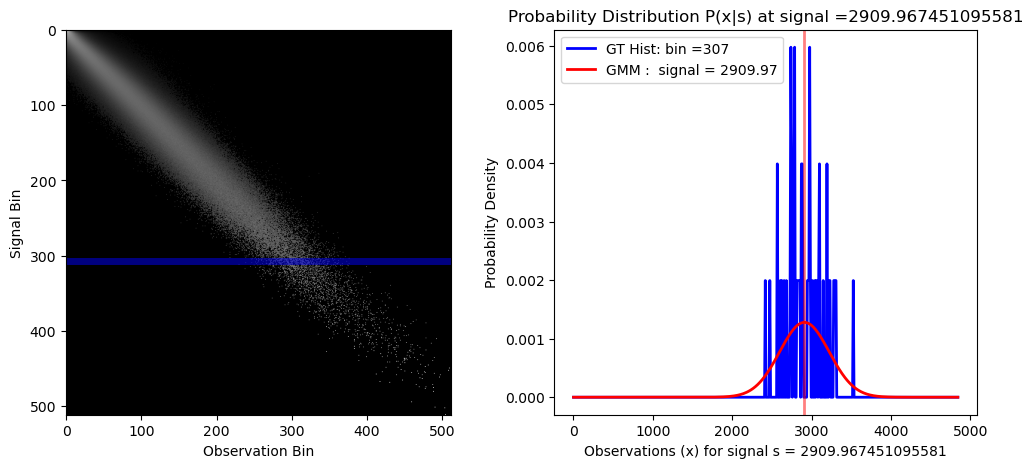

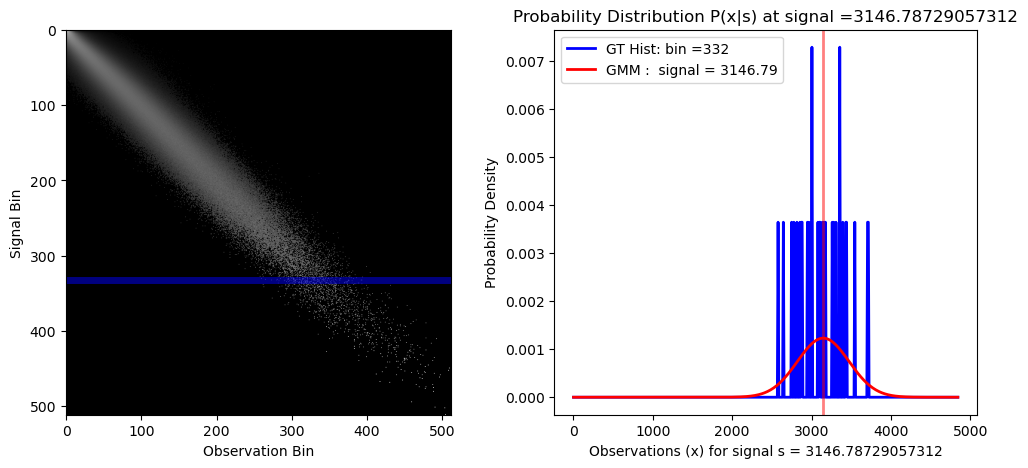

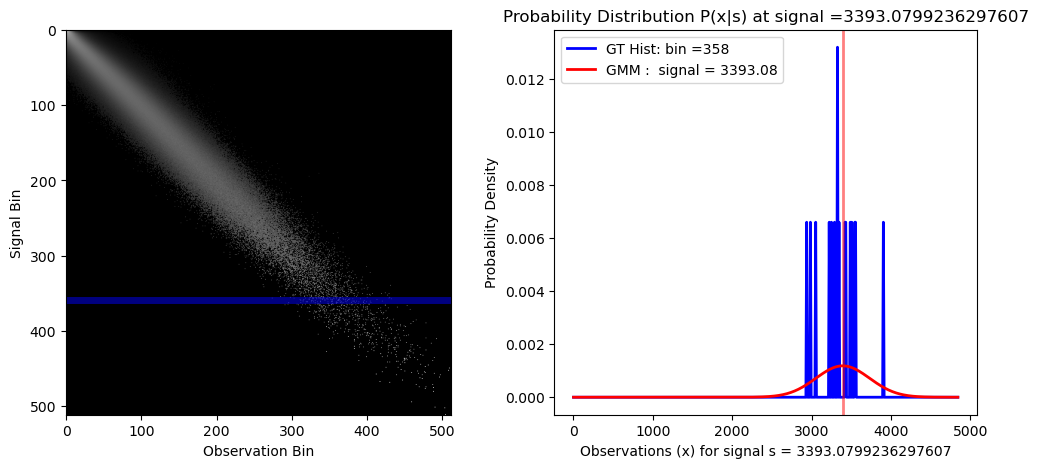

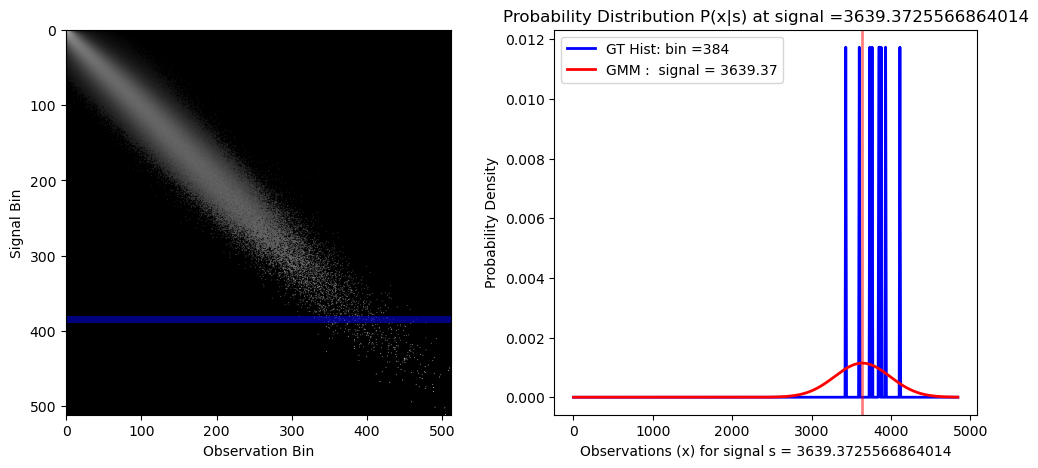

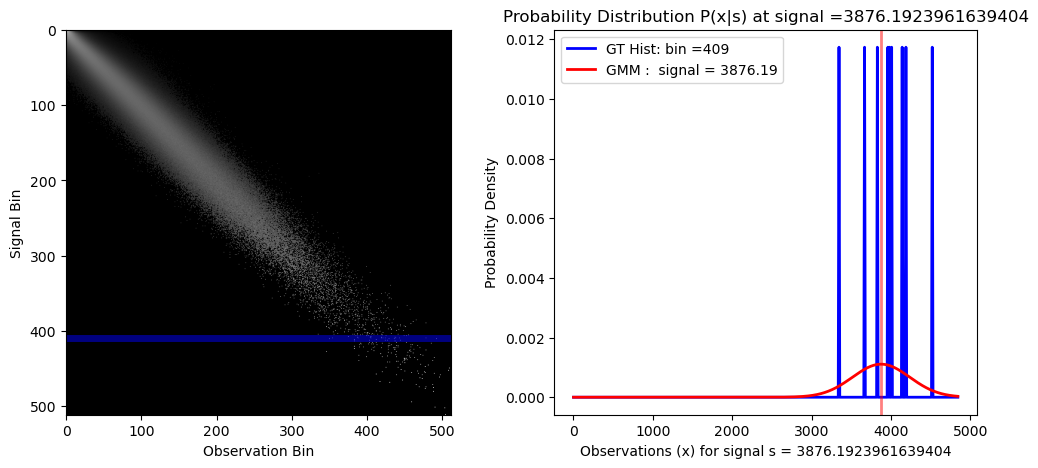

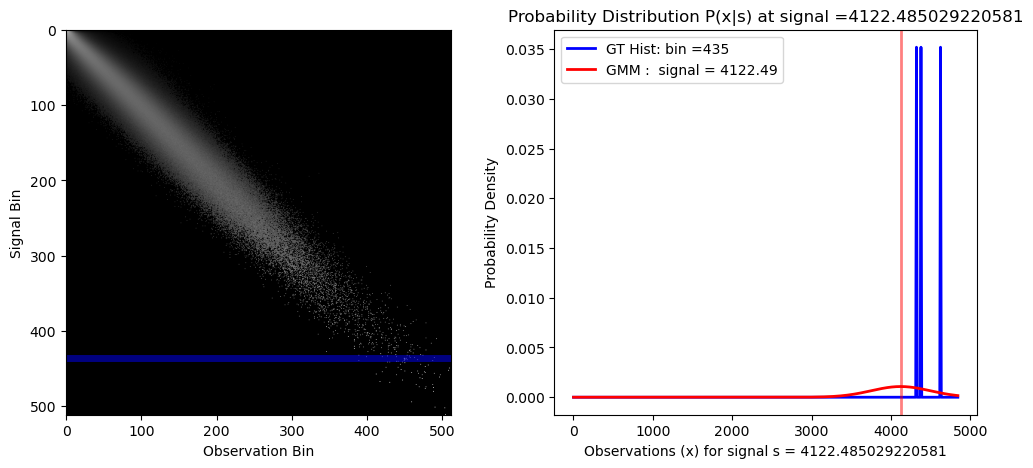

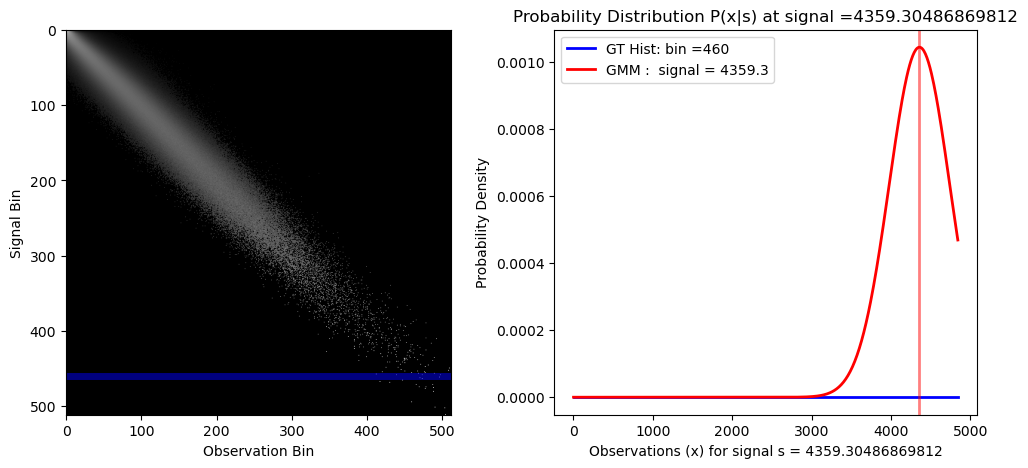

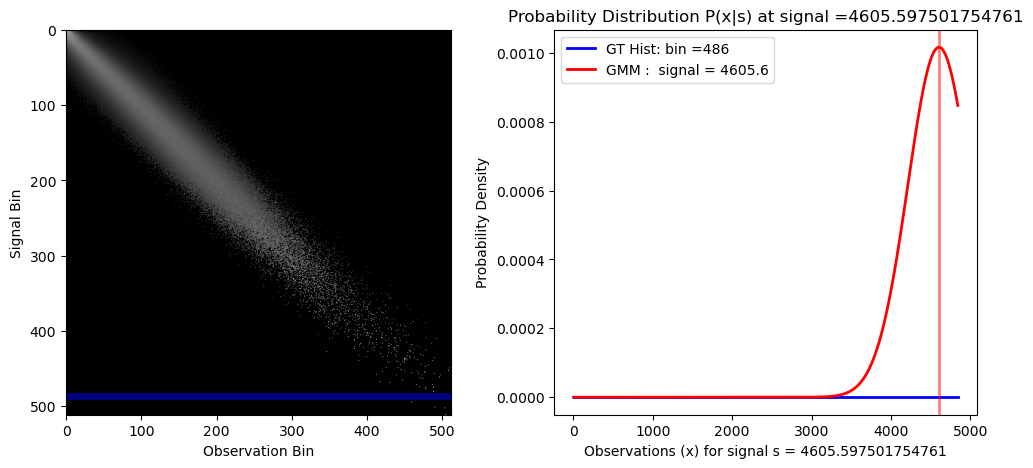

In [171]:
# Check GMM perf
GMMname = fullnameGMMNoiseModel[1::]+".npz" # to check current one
print(GMMname)
# GMMname = r"final_noReg/GMM_Noise0_SigN2V_Clip-3.npz"# to check existing one

n_points = 20
signalBinIndex_list = (np.linspace(0,n_points-1,n_points)*hist_bins//n_points).astype(int)
GMMmodel_prm = np.load(os.path.join(noiseModelsDir,GMMname))
GMMmodel = GaussianMixtureNoiseModel(params = GMMmodel_prm, device = device) 
# GMMmodel = gaussianMixtureNoiseModel
# GMMmodel.weight = torch.tensor([[ 1.8706, 0],
#         [-0.4762,  2.5608],
#         [ 0.9983, -1.9992]], device='cuda:0', requires_grad=True)


for binidx in signalBinIndex_list:
    plotProbabilityDistribution(signalBinIndex=binidx, histogram=histogram[0], gaussianMixtureNoiseModel=GMMmodel, min_signal=minVal, max_signal=maxVal, n_bin=hist_bins, device=device)

In [169]:
def plotProbabilityDistribution2(histogram, gaussianMixtureNoiseModel, min_signal, max_signal, n_bin, device,signalBinIndex_list):
    """Plots probability distribution P(x|s) for a certain ground truth signal. 
       Predictions from both Histogram and GMM-based Noise models are displayed for comparison.
        Parameters
        ----------
        signalBinIndex: int
            index of signal bin. Values go from 0 to number of bins (`n_bin`).
        histogram: numpy array
            A square numpy array of size `nbin` times `n_bin`.
        gaussianMixtureNoiseModel: GaussianMixtureNoiseModel
            Object containing trained parameters.
        min_signal: float
            Lowest pixel intensity present in the actual sample which needs to be denoised.
        max_signal: float
            Highest pixel intensity present in the actual sample which needs to be denoised.
        n_bin: int
            Number of Bins.
        device: GPU device
        """

    fig = plt.figure(figsize=(12, 5))
    
    for i,binidx in enumerate(signalBinIndex_list):

        # print(gaussianMixtureNoiseModel.weight)
        histBinSize=(max_signal-min_signal)/n_bin
        querySignal_numpy= (binidx/float(n_bin)*(max_signal-min_signal)+min_signal)
        querySignal_numpy +=histBinSize/2
        querySignal_torch = torch.from_numpy(np.array(querySignal_numpy)).float().to(device)
        
        queryObservations_numpy=np.arange(min_signal, max_signal, histBinSize)
        queryObservations_numpy+=histBinSize/2
        queryObservations = torch.from_numpy(queryObservations_numpy).float().to(device)
        pTorch=gaussianMixtureNoiseModel.likelihood(queryObservations, querySignal_torch)
        pNumpy=pTorch.cpu().detach().numpy()

        plt.subplot(1, 2, 1)
        plt.xlabel('Observation (x)')
        plt.ylabel('Signal (s)')
        plt.imshow(histogram**0.25, cmap='gray')
        plt.axhline(y=binidx+0.5, linewidth=5, color='white', alpha=0.5)
        plt.title("Histogram Noise Model")
        
        plt.subplot(1, 2, 2)
        if i ==0:
            plt.plot(queryObservations_numpy, histogram[binidx, :]/histBinSize, label='Histogram', color='black', linewidth=1)
            plt.plot(queryObservations_numpy, pNumpy, label='GMM', color='red',linewidth=2)
        else:
            plt.plot(queryObservations_numpy, histogram[binidx, :]/histBinSize, color="black", linewidth=1)
            plt.plot(queryObservations_numpy, pNumpy, color='red',linewidth=2)
        # plt.axvline(x=querySignal_numpy, linewidth=2, color='red', alpha=0.5)
        
        plt.xlabel('Observations')
        plt.ylabel('Probability Density')
        plt.title("Probability Distribution P(x|s)")
        plt.legend()

    plt.savefig("fig.svg")

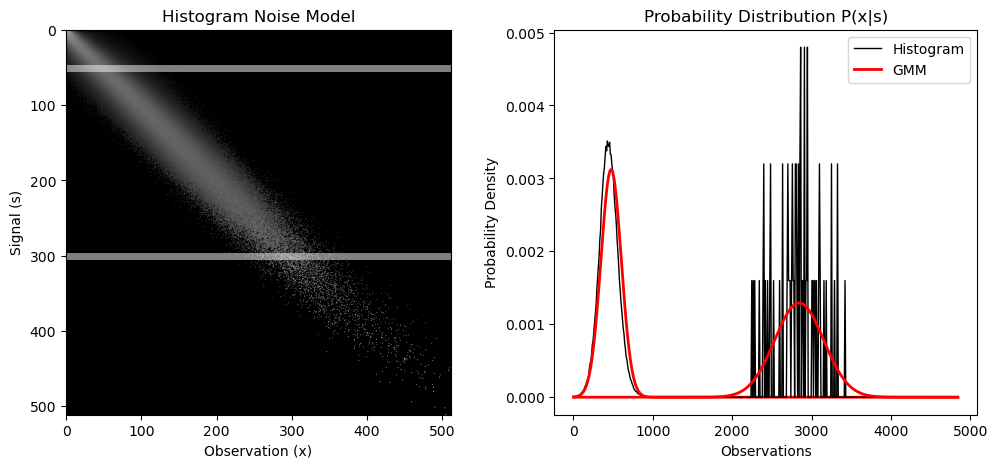

In [170]:
plotProbabilityDistribution2(histogram=histogram[0], gaussianMixtureNoiseModel=GMMmodel, min_signal=minVal, max_signal=maxVal, n_bin=hist_bins, device=device,signalBinIndex_list=[50,300])